# Project 3


In [ ]:
!pip install scikit-surprise==1.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/UCLA Courses/219/Project 3'

/content/drive/MyDrive/UCLA Courses/219/Project 3


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import surprise
from surprise.prediction_algorithms.knns import KNNBasic,KNNWithMeans
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
import sklearn.metrics as metrics
from surprise import accuracy
from surprise import Reader
from surprise import Dataset
from surprise import model_selection
from surprise.model_selection import cross_validate
from pandas.core.indexes.interval import maybe_extract_name
from surprise.model_selection import KFold
from surprise.model_selection.split import train_test_split
from surprise.prediction_algorithms.matrix_factorization import NMF
import sklearn
from surprise.prediction_algorithms.matrix_factorization import SVD

In [ ]:
data = pd.read_csv('ratings.csv')
movie_titles_genre = pd.read_csv("movies.csv")
data = data.merge(movie_titles_genre,on='movieId', how='left')
#data.head(10)
Average_ratings = pd.DataFrame(data.groupby('title')['rating'].mean())
Average_ratings['Total Ratings'] = 
pd.DataFrame(data.groupby('title')['rating'].count())
#Average_ratings.head(10)

In [ ]:
data

,Unnamed: 0,userId,movieId,rating,timestamp,title,genres
0,0,496,112852,3.0,1415520462,Guardians of the Galaxy (2014),Action|Adventure|Sci-Fi
1,1,391,1947,4.0,1030945141,West Side Story (1961),Drama|Musical|Romance
2,2,387,1562,1.5,1095041022,Batman & Robin (1997),Action|Adventure|Fantasy|Thriller
3,3,474,2716,4.5,1053020930,Ghostbusters (a.k.a. Ghost Busters) (1984),Action|Comedy|Sci-Fi
4,4,483,88125,4.5,1311337237,Harry Potter and the Deathly Hallows: Part 2 (...,Action|Adventure|Drama|Fantasy|Mystery|IMAX
...,...,...,...,...,...,...,...
100831,100831,469,1219,4.0,965661925,Psycho (1960),Crime|Horror
100832,100832,599,3571,2.0,1498511343,Time Code (2000),Comedy|Drama
100833,100833,414,276,3.0,961596299,Milk Money (1994),Comedy|Romance
100834,100834,395,168,3.0,841503984,First Knight (1995),Action|Drama|Romance


QUESTION 1: Explore the Dataset: In this question, we explore the structure of the data.<br>
A Compute the sparsity of the movie rating dataset:

In [ ]:
m = max(data['userId'])#number of users
n = Average_ratings.shape[0]#number of movies
sparsity = Average_ratings['Total Ratings'].sum()/(m*n)
print('Sparsity = ',sparsity)

Sparsity =  0.0170084286482958


B Plot a histogram showing the frequency of the rating values. Comment on the shape of the histogram.<br>
*See below for the plot. We notice that the majority of movies are given ratings between 4-4.5. No movies have been rated less than 0.5 which is why the bin intervals start from 0.5*

Text(0.5, 1.0, 'Question 1 part B: Histogram of frequency of rating values')

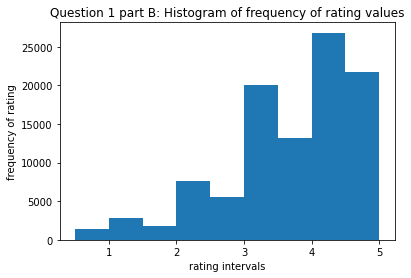

In [ ]:
movie_user = data.pivot_table(index='userId',columns='title',values='rating')
#display(movie_user)
R = np.array(movie_user)
bins = np.arange(0.5,5.5,0.5)
plt.figure()
h = plt.hist(R.reshape(-1),bins)
plt.xlabel('rating intervals')
plt.ylabel('frequency of rating')
plt.title('Question 1 part B: Histogram of frequency of rating values')

C Plot the distribution of the number of ratings received among movies:

Text(0.5, 1.0, 'distribution of the number of ratings received among movies')

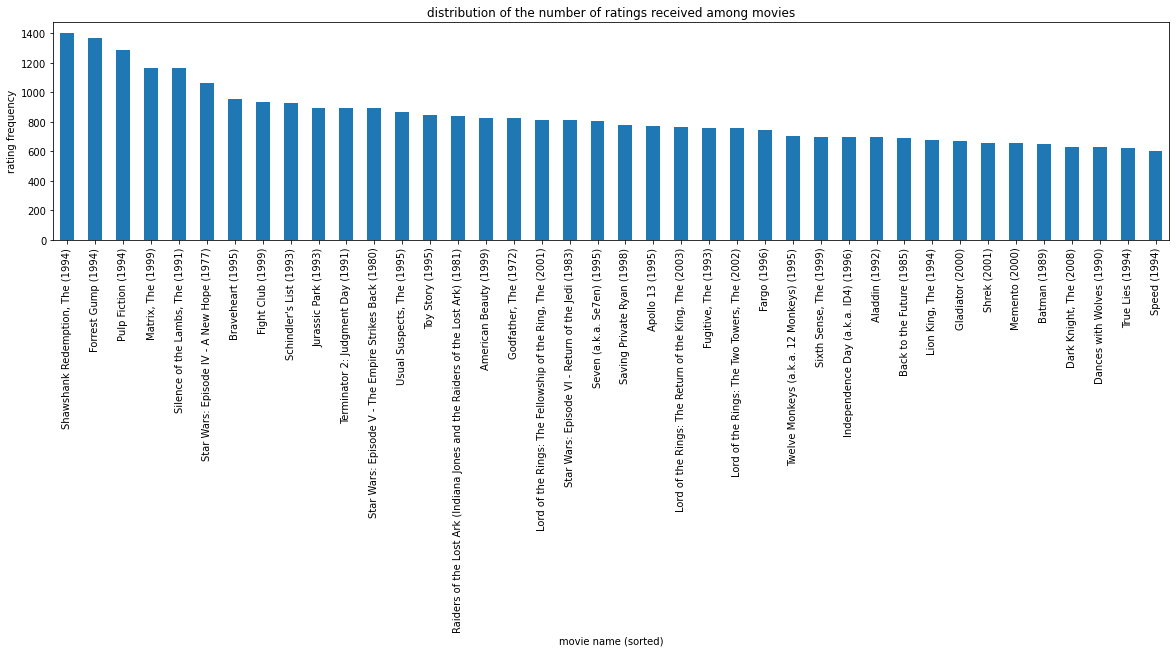

In [ ]:
movie_rate = movie_user.sum(axis=0)
df = movie_rate.sort_values(ascending=False)
#display(df)
plt.figure(figsize=(20,4))
df.iloc[:40].plot.bar()
plt.xlabel('movie name (sorted)')
plt.ylabel('rating frequency')
plt.title('distribution of the number of ratings received among movies')



D Plot the distribution of ratings among users

Text(0.5, 1.0, 'distribution of the number of ratings among users')

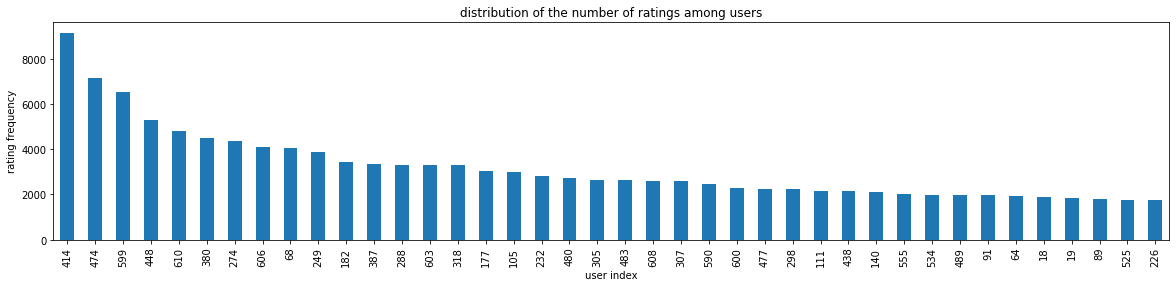

In [ ]:
user_rate = movie_user.sum(axis=1)
df = user_rate.sort_values(ascending=False)
#display(df)
plt.figure(figsize=(20,4))
df.iloc[:40].plot.bar()
plt.xlabel('user index')
plt.ylabel('rating frequency')
plt.title('distribution of the number of ratings among users')

E Discuss the salient features of the distributions from Questions C,D and their implications for the recommendation process. <br>
*We realize that many movies don't have many ratings. Also some users are not as active as others in rating. This can cause a problem when we are trying to recommend movies to inactive users because we don't have enough data from those users. Also, movies that have not received many ratings might not be grouped correctly into appropriate recommendation groups.*

F Compute the variance of the rating values received by each movie. Briefly comment on the shape of the resulting histogram. <br>
*We see that the majority of movies have a low rating variance. Meaning that the ratings are relatively consistent and don't change much across users that hace rated that movie.*

Text(0.5, 1.0, 'Question 1 part F: Histogram of variance of the rating values received by each movie')

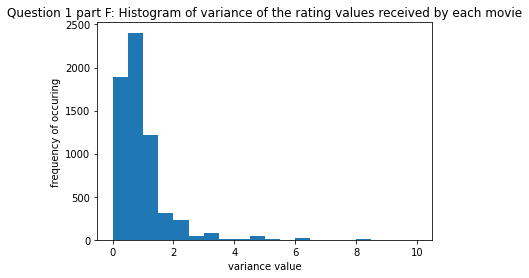

In [ ]:
variances = movie_user.var(axis=0,numeric_only=True)
bins = np.arange(variances.min(),variances.max(),0.5)
plt.figure()
h = plt.hist(variances,bins)
plt.xlabel('variance value')
plt.ylabel('frequency of occuring')
plt.title('Question 1 part F: Histogram of variance of the rating values received by each movie')

QUESTION 2: Understanding the Pearson Correlation Coefficient:<br>
A Write down the formula for μu in terms of Iu and ruk;<br>
$$\mu_u = \frac{1}{|I_u|}\sum_{k\in I_u}r_{uk} $$
B In plain words, explain the meaning of Iu ∩ Iv. Can Iu ∩ Iv = ∅? (Hint: Rating matrix R is sparse) <br>
*$I_u \cap I_v$ denotes the set of indices of movies that both users u and v have rated. Yes it can be empty in the case that the movies users u and v have rated are completely different and they haven't rated any common movies.* <br>
<br>
QUESTION 3: Understanding the Prediction function: Can you explain the reason behind mean-centering the raw ratings (rvj − μv) in the prediction function? (Hint: Consider users who either rate all items highly or rate all items poorly and the impact of these users on the prediction function.)<br>
*By this method, we are trying to minimize the effect of neighbor user biases. For example, if a neighbor user tends to rate every movie highly, we don't want that to affect our prediction for the new user's rating.* 

QUESTION 4: Design a k-NN collaborative filter to predict the ratings of the movies in the original dataset and evaluate its performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis) and average MAE (Y-axis) against k (X-axis).

In [ ]:
reader = Reader(rating_scale=(0.5, 5))
#reader = Reader(line_format='user item rating timestamp', sep=',',skip_lines=1, rating_scale=(0.5, 5))
df = Dataset.load_from_df(data[['userId','movieId','rating']], reader)
#df = Dataset.load_from_file('ratings.csv',reader)
K = np.arange(2,102,2)
RMSE = []
MAE = []
sim_options = {"name": "pearson"}

for k in K:
  #print('k=',k)
  model = KNNWithMeans(k=k,sim_options=sim_options, verbose=False)#KNNBasic(k=k,sim_options=sim_options, verbose=False)
  results = cross_validate(model, df, measures=['RMSE','MAE'], cv=10, verbose=False)
  RMSE.append(results['test_rmse'].mean())
  MAE.append(results['test_mae'].mean())


Text(0.5, 1.0, 'Question 4: k-NN collaborative filter performance evaluation')

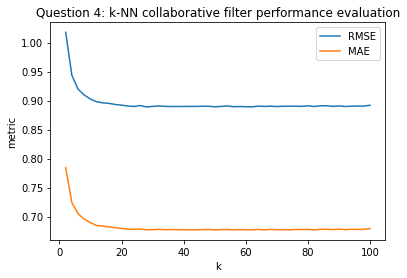

In [ ]:
plt.figure()
plt.plot(K,RMSE)
plt.plot(K,MAE)
plt.legend(['RMSE','MAE'])
plt.xlabel('k')
plt.ylabel('metric')
plt.title('Question 4: k-NN collaborative filter performance evaluation')

QUESTION 5: Use the plot from question 4, to find a ’minimum k’. Note: The term ’minimum k’ in this context means that increasing k above the minimum value would not result in a significant decrease in average RMSE or average MAE. If you get the plot correct, then ’minimum k’ would correspond to the k value for which average RMSE and average MAE converges to a steady-state value. Please report the steady state values of average RMSE and average MAE.<br>
*see below:*

In [ ]:
k_best = 20
idx = 9
best_RMSE = RMSE[idx]
best_MAE = MAE[idx]
print(f'steady state k={K[idx]}, steady state RMSE={best_RMSE}, steady state MAE = {best_MAE}')

steady state k=20, steady state RMSE=0.892089822277119, steady state MAE = 0.6797351707361999


QUESTION 6: Within EACH of the 3 trimmed subsets in the dataset, design:
A k-NN collaborative filter to predict the ratings of the movies (i.e Popular, Unpopular or High- Variance) and evaluate each of the three models’ performance using 10-fold cross validation:
* Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE.<br>
Please see below:


https://stackoverflow.com/questions/49137031/pandas-dataframe-delete-rows-with-low-frequency

In [ ]:
df_popular = data[data.groupby('movieId')['movieId'].transform('count').ge(3)]
df_unpopular = data[data.groupby('movieId')['movieId'].transform('count').le(2)]
df_lowvar = data[data.groupby('movieId')['rating'].transform('var').ge(2)]
df_3 = df_lowvar[df_lowvar.groupby('movieId')['movieId'].transform('count').ge(5)]

In [ ]:

K = np.arange(2,102,2)
kf = KFold(n_splits=10)
RMSE = {'popular':[],'unpopular':[],'high_var':[]}
MAE = {'popular':[],'unpopular':[],'high_var':[]}
trim_algs = ['popular','unpopular','high_var']
dfs = [data,df_popular,df_unpopular,df_3]

for k in K:
  #print('k=',k)
  model = KNNWithMeans(k=k,sim_options={"name": "pearson"}, verbose=False)#KNNBasic(k=k,sim_options={"name": "pearson"}, verbose=False)
  reader = Reader(rating_scale=(0.5, 5))

  for (title,df) in zip(trim_algs,dfs):
    df_new = Dataset.load_from_df(df[['userId','movieId','rating']], reader)
    rmse = []
    mae = []
    for trainset, testset in kf.split(df_new):
      # train and test algorithm.
      model.fit(trainset)
      predictions = model.test(testset)
      # Compute and print Root Mean Squared Error
      rmse.append(accuracy.rmse(predictions, verbose=False))
      mae.append(accuracy.mae(predictions, verbose=False))
    RMSE[title].append(np.array(rmse).mean())
    MAE[title].append(np.array(mae).mean())
    #print(f'Done with trimming algorithm: {title}')
    



In [ ]:
trim_algs = ['popular','unpopular','high_var']
for title in trim_algs:
  print(f'minimum RMSE for trimming algorithm {title} is {min(RMSE[title])}')

minimum RMSE for trimming algorithm popular is 0.8883085402345081
minimum RMSE for trimming algorithm unpopular is 0.8688223075275735
minimum RMSE for trimming algorithm high_var is 1.0534946036945114


Text(0.5, 1.0, 'RMSE vs k for different trimming algorithms')

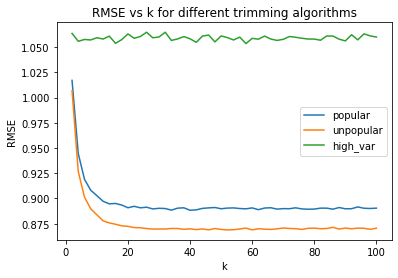

In [ ]:
plt.figure()
for title in trim_algs:
  plt.plot(K,RMSE[title])
plt.xlabel('k')
plt.ylabel('RMSE')
plt.legend(trim_algs)
plt.title('RMSE vs k for different trimming algorithms')

Text(0.5, 1.0, 'MAE vs k for different trimming algorithms')

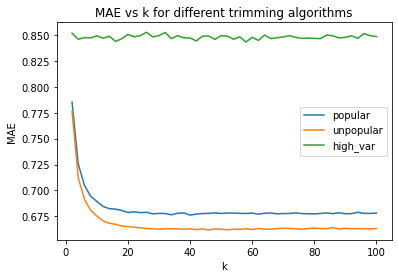

In [ ]:
plt.figure()
for title in trim_algs:
  plt.plot(K,MAE[title])
plt.xlabel('k')
plt.ylabel('MAE')
plt.legend(trim_algs)
plt.title('MAE vs k for different trimming algorithms')

* Plot the ROC curves for the k-NN collaborative filters for threshold values [2.5, 3, 3.5, 4]. These thresholds are applied only on the training set. For each of the plots, also report the area under the curve (AUC) value. You should have 4 × 4 plots in this section (4 trimming options – including no trimming times 4 thresholds) - all thresholds can be condensed into one plot per trimming option yielding only 4 plots.<b>
Please see below:

working on threshold value=2.5
working on threshold value=3
working on threshold value=3.5
working on threshold value=4


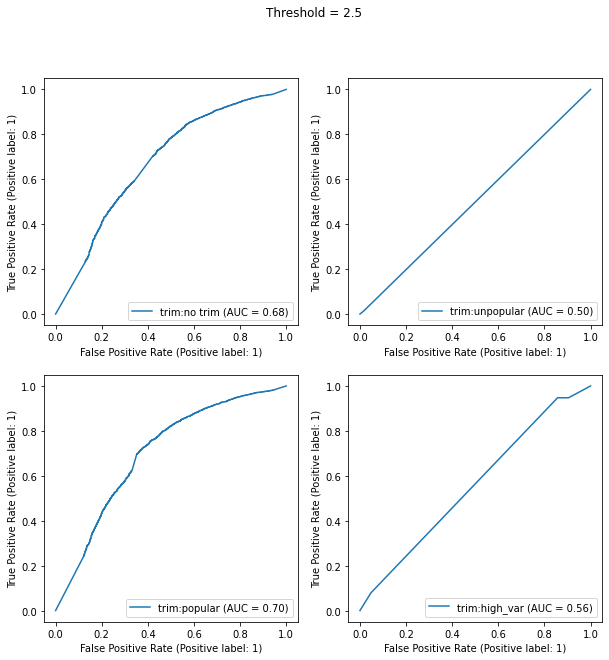

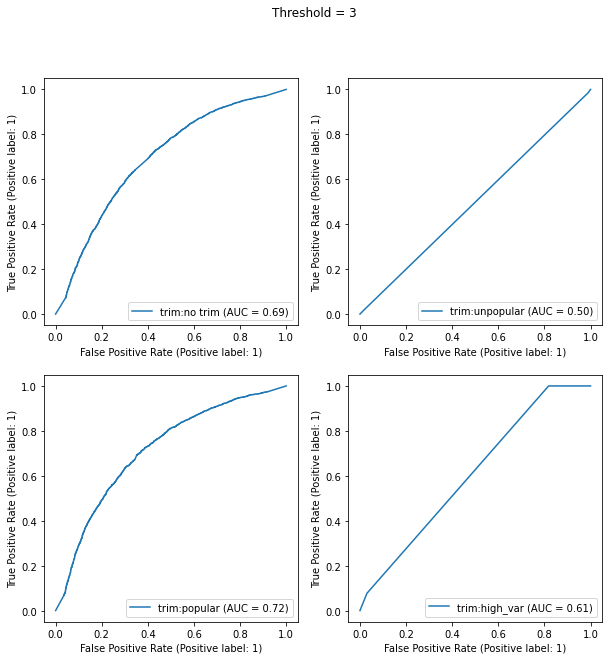

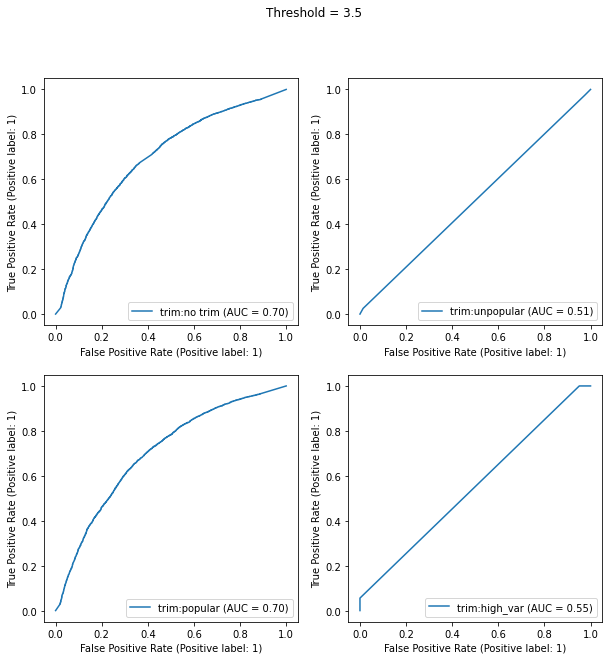

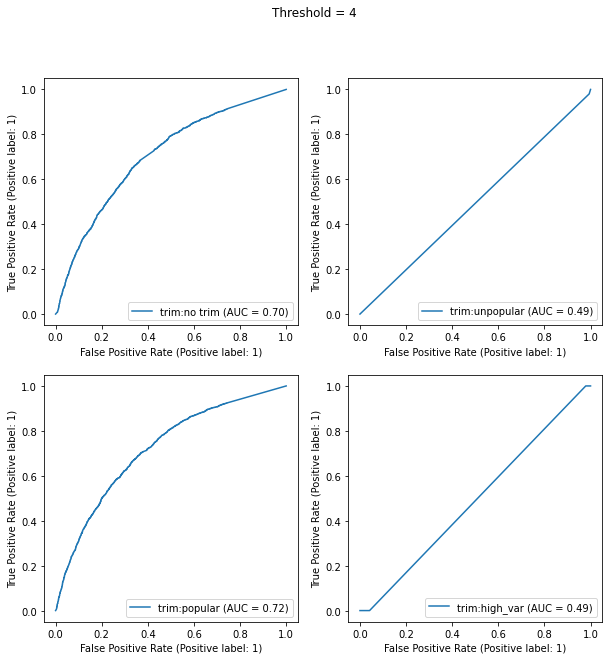

In [ ]:
k=20 #based on observations in previous step
thresholds = [2.5, 3, 3.5, 4]
trim_algs = ['no trim','popular','unpopular','high_var']
dfs = [data,df_popular,df_unpopular,df_3]
for cutoff in thresholds:

  print(f'working on threshold value={cutoff}')
  model = KNNBasic(k=k,sim_options={"name": "pearson"}, verbose=False)
  reader = Reader(rating_scale=(0, 1))

  fig, axs = plt.subplots(2,2,figsize=(10,10))
  fig.suptitle(f'Threshold = {cutoff}')

  for (i,df) in enumerate(dfs):

    df1 = df.copy()
    df1['rating'] = df1['rating'].apply(lambda x: 1 if x > cutoff else 0)
    df_new = Dataset.load_from_df(df1[['userId','movieId','rating']], reader)
    trainset, testset = train_test_split(df_new, test_size=0.1)
    model.fit(trainset)
    predictions = model.test(testset)

    y = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
    a = i%2
    b = (i//2)%2
    metrics.RocCurveDisplay.from_predictions(y['rui'], y['est'], name=f'trim:{trim_algs[i]}', ax=axs[a,b])

    


QUESTION 7: Understanding the NMF cost function: Is the optimization problem given by equation 5 convex? Consider the optimization problem given by equation 5. For U fixed, formulate it as a least-squares problem.<br>
*Noting that the objective in equation 5 is a function of both U and V, it is NOT a convex function. The reason is that if $U_0$ and $V_0$ are optimal solutions, for any orthogonal matrix $Q\in \mathbb{R}^{k\times k}$, $U_0Q$ and $V_0Q$ are also optimal. Now 
So local minima are not necessarily the global minimum and we might get stuck in local minima. If we choose some $U$ as a convex combination of $U_0$ and $U_0Q$, and $V$ as a convex combination of $V_0$ and $V_0Q$, the cost function has to be constant but it doesn't happen which is in contradiction with convexity.* <br>
$$ \sum_{i=1}^m \sum_{j=1}^n W_{ij}(r_{ij} - u_i v_j^T)^2 = \sum_{i=1}^m \sum_{j=1}^n W_{ij}(r_{ij} - \sum_{l=1}^k u_{il} v_{jl})^2 $$
Where $u_i$ and $v_j$ are rows of matrices $U$ and $V$, respectively. Now we note that in order to minimize the cost function For constant $u_{ik}$, it's sufficient to minimize $(r_{ij} - \sum_{l=1}^k u_{il} v_{jl})^2$ and find each $v_{jl}$ we see that this is a least squares problem in terms of variables $v_{jl}$ .

QUESTION 8: Designing the NMF Collaborative Filter:<br>
A Design a NMF-based collaborative filter to predict the ratings of the movies in the original dataset and evaluate its performance using 10-fold cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. If NMF takes too long, you can increase the step size. Increasing it too much will result in poorer granularity in your results. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Y- axis) against k (X-axis). For solving this question, use the default value for the regularization parameter.

In [ ]:
reader = Reader(rating_scale=(0.5, 5))
df_new = Dataset.load_from_df(data[['userId','movieId','rating']], reader)
kf = KFold(n_splits=10)
K = np.arange(2,52,2)

RMSE = []
MAE = []
for k in K:
  #print(k)
  model = NMF(n_factors=k, random_state=0)
  rmse = []
  mae = []
  for trainset, testset in kf.split(df_new):
      # train and test algorithm.
      model.fit(trainset)
      predictions = model.test(testset)
      # Compute and print Root Mean Squared Error
      rmse.append(accuracy.rmse(predictions, verbose=False))
      mae.append(accuracy.mae(predictions, verbose=False))
  RMSE.append(np.array(rmse).mean())
  MAE.append(np.array(mae).mean())


Text(0.5, 1.0, 'Question 8 A: NMF collaborative filter performance evaluation')

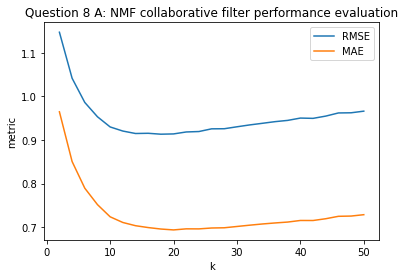

In [ ]:
plt.figure()
plt.plot(K,RMSE)
plt.plot(K,MAE)
plt.legend(['RMSE','MAE'])
plt.xlabel('k')
plt.ylabel('metric')
plt.title('Question 8 A: NMF collaborative filter performance evaluation')

B Use the plot from the previous part to find the optimal number of latent factors. Optimal number of latent factors is the value of k that gives the minimum average RMSE or the minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal number of latent factors same as the number of movie genres?<br>
*Please see below. Based on the readme file, there are 18 different genres which is equal to the optimal k based on minimum RMSE.*
* Action
* Adventure
* Animation
* Children's
* Comedy
* Crime
* Documentary
* Drama
* Fantasy
* Film-Noir
* Horror
* Musical
* Mystery
* Romance
* Sci-Fi
* Thriller
* War
* Western

In [ ]:
print('minimum RMSE = ',min(RMSE))
print('minimum MAE = ',min(MAE))
print('optimal k value based on RMSE: ',K[RMSE.index(min(RMSE))])
print('optimal k value based on MAE: ',K[MAE.index(min(MAE))])

minimum RMSE =  0.9133129063144583
minimum MAE =  0.6935211727963345
optimal k value based on RMSE:  18
optimal k value based on MAE:  20


C Performance on trimmed dataset subsets: For each of Popular, Unpopular and High-Variance subsets:
* Design a NMF collaborative filter to predict the ratings of the movies in the trimmed subset and evaluate its performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds.
* Plot average RMSE (Y-axis) against k (X-axis); item Report the minimum average RMSE.

In [ ]:
K = np.arange(2,52,2)
kf = KFold(n_splits=10)
RMSE = {'popular':[],'unpopular':[],'high_var':[]}
MAE = {'popular':[],'unpopular':[],'high_var':[]}
trim_algs = ['popular','unpopular','high_var']
dfs = [df_popular,df_unpopular,df_3]

for k in K:
  #print('k=',k)
  model = NMF(n_factors=k, random_state=0)
  reader = Reader(rating_scale=(0.5, 5))

  for (title,df) in zip(trim_algs,dfs):
    df_new = Dataset.load_from_df(df[['userId','movieId','rating']], reader)
    rmse = []
    mae = []
    for trainset, testset in kf.split(df_new):
      
      model.fit(trainset)
      predictions = model.test(testset)

      rmse.append(accuracy.rmse(predictions, verbose=False))
      mae.append(accuracy.mae(predictions, verbose=False))
    RMSE[title].append(np.array(rmse).mean())
    MAE[title].append(np.array(mae).mean())
    #print(f'Done with trimming algorithm: {title}')
    

minimum RMSE for trimming popular is 0.8917210395482765
minimum RMSE for trimming unpopular is 1.1300208684394473
minimum RMSE for trimming high_var is 1.4428100315686758


Text(0.5, 1.0, 'RMSE vs k for different trimming algorithms')

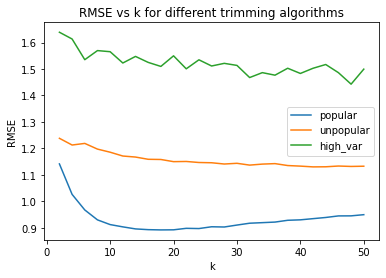

In [ ]:
plt.figure()
for title in trim_algs:
  plt.plot(K,RMSE[title])
  print(f'minimum RMSE for trimming {title} is {min(RMSE[title])}')
plt.xlabel('k')
plt.ylabel('RMSE')
plt.legend(trim_algs)
plt.title('RMSE vs k for different trimming algorithms')

* Plot the ROC curves for the NMF-based collaborative filter and also report the area under the
curve (AUC) value as done in Question 6. <br>
NOTE: I noticed that without bias, NMF performs very poorly so I am adding biased=True. Also, due to Zero division error, I had to relabel the ratings as -1,1 instead of 0,1 to plot ROC curves.

working on threshold value=2.5
no trim
popular
unpopular
high_var
working on threshold value=3
no trim
popular
unpopular
high_var
working on threshold value=3.5
no trim
popular
unpopular
high_var
working on threshold value=4
no trim
popular
unpopular
high_var


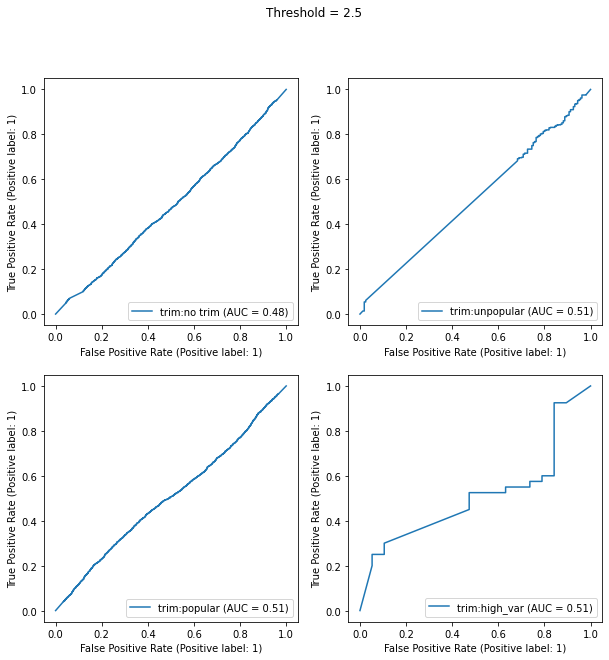

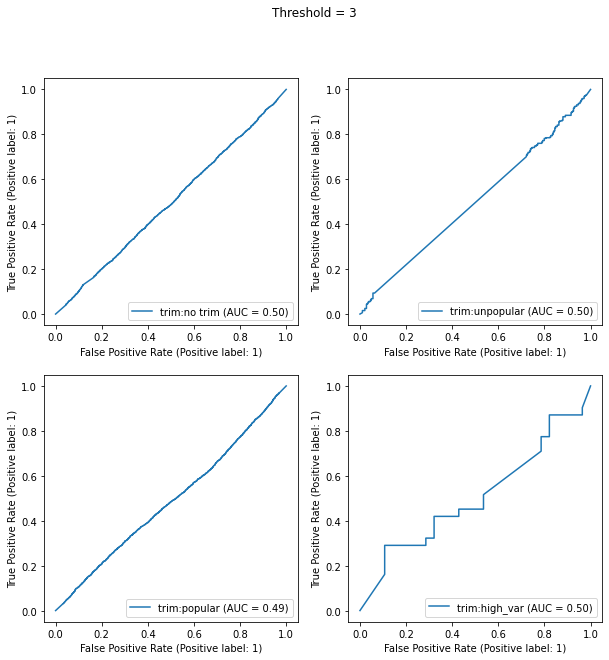

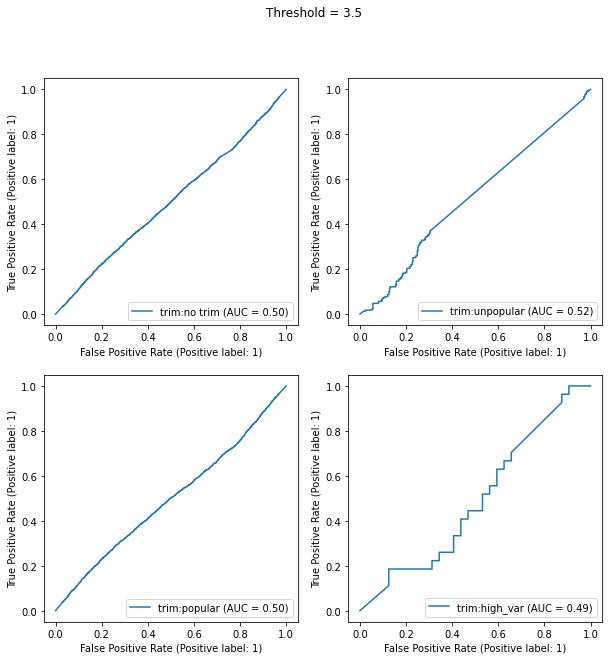

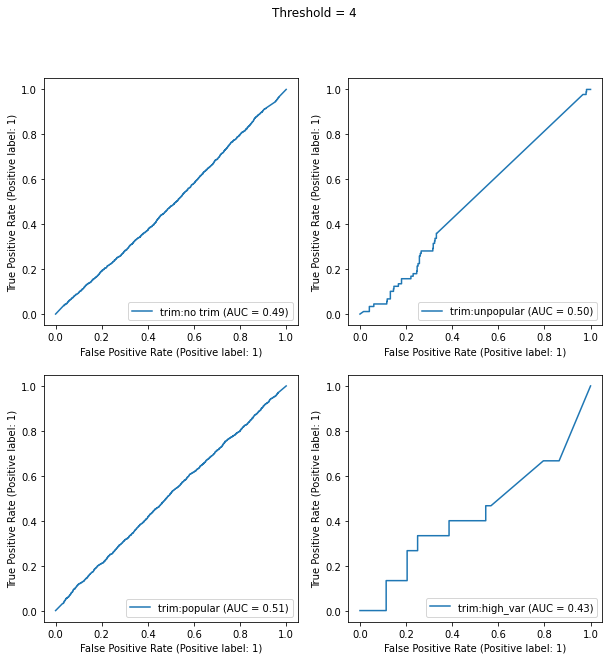

In [ ]:
k=18 #based on observations in previous step
thresholds = [2.5, 3, 3.5, 4]
dfs = [data, df_popular, df_unpopular, df_3]
trim_algs = ['no trim','popular','unpopular','high_var']
for cutoff in thresholds:

  print(f'working on threshold value={cutoff}')
  model = NMF(n_factors=k, random_state=0, biased=False)
  reader = Reader(rating_scale=(-1, 1))

  fig, axs = plt.subplots(2,2,figsize=(10,10))
  fig.suptitle(f'Threshold = {cutoff}')

  for (i,df) in enumerate(dfs):
    print(trim_algs[i])
    df1 = df.copy()
    df1['rating'] = df1['rating'].apply(lambda x: 1 if x > cutoff else -1)
    df_new = Dataset.load_from_df(df1[['userId','movieId','rating']], reader)
    trainset, testset = train_test_split(df_new, test_size=0.1,random_state=42)
    
    model.fit(trainset)
    predictions = model.test(testset)

    y = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
    a = i%2
    b = (i//2)%2
    metrics.RocCurveDisplay.from_predictions(y['rui'], y['est'], name=f'trim:{trim_algs[i]}', ax=axs[a,b])


QUESTION 9: Interpreting the NMF model: Perform Non-negative matrix factorization on the ratings matrix R to obtain the factor matrices U and V , where U represents the user-latent factors interaction and V represents the movie-latent factors interaction (use k = 20). For each column of V , sort the movies in descending order and report the genres of the top 10 movies. Do the top 10 movies belong to a particular or a small collection of genre? Is there a connection between the latent factors and the movie genres? <br>
*See below. Yes the genres are mostly focused on a small group. For example the first column movies mostly have Action/Adventure genre. Second column is a bit more in Adventure/Fantasy and column three has more Drama. Basically, the latent factors show the dominant theme of the movies which can include multiple close genres.* 


In [ ]:
import sklearn.decomposition
movie_user = data.pivot_table(index='userId',columns='title',values='rating')#.fillna(0)
display(movie_user)
R = np.array(movie_user.fillna(0))
reader = Reader(rating_scale=(0.5, 5))
#R = Dataset.load_from_df(movie_user,reader)
model = sklearn.decomposition.NMF(n_components=20, random_state=0)
#R_df = pd.DataFrame(R).fillna(0)
model.fit(R)
U = model.fit_transform(R)
V = model.components_.T

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [ ]:
movies = movie_user.columns
for i in range(3):

  print(f'top 10 movie genres in column {i} of V:')
  idx = np.argsort(V[:,i])[::-1]
  for id in idx[:10]:
    genre = movie_titles_genre['genres'][movie_titles_genre['title']==movies[id]]
    print(genre.iloc[0])
  print("------------------------------------------------")


top 10 movie genres in column 0 of V:
Action|Sci-Fi|Thriller
Action|Adventure|Comedy|Sci-Fi
Adventure|Animation|Children|Comedy|Fantasy|Romance
Action|Adventure|Sci-Fi|Thriller
Action|Drama|Romance
Action|Adventure|Sci-Fi
Action|Mystery|Thriller
Action|Adventure|Drama
Action|Crime|Mystery|Sci-Fi|Thriller
Comedy|Crime|Thriller
------------------------------------------------
top 10 movie genres in column 1 of V:
Action|Adventure|Drama|Fantasy
Adventure|Fantasy
Action|Adventure|Sci-Fi
Adventure|Fantasy
Action|Adventure|Sci-Fi
Action|Adventure|Sci-Fi|IMAX
Adventure|Animation|Children|Romance|Sci-Fi
Action|Adventure
Adventure|Animation|Children|Drama
Action|Crime|Drama|IMAX
------------------------------------------------
top 10 movie genres in column 2 of V:
Thriller
Action|Drama|War
Adventure|Drama|IMAX
Comedy|Drama|Romance|War
Adventure|Drama|Western
Crime|Drama
Action|Adventure|Comedy|Romance|Thriller
Comedy|Crime|Drama|Thriller
Action|Adventure|Sci-Fi|Thriller
Action|Crime|Thriller
--

QUESTION 10: Designing the MF Collaborative Filter:<br>
A Design a MF-based collaborative filter to predict the ratings of the movies in the original dataset and evaluate it’s performance using 10-fold cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Y-axis) against k (X-axis). For solving this question, use the default value for the regularization parameter.<br>
*See below. Comparing the given optimization function for this question and the documentation of Surprise, I realized that SVD was the correct choice. In my experiments, all choices of k result in a similar performance.*

In [ ]:

reader = Reader(rating_scale=(0.5, 5))
df_new = Dataset.load_from_df(data[['userId','movieId','rating']], reader)
kf = KFold(n_splits=10)
K = np.arange(2,52,2)

RMSE = []
MAE = []
for k in K:
  model = SVD(n_factors=k)
  rmse = []
  mae = []
  for trainset, testset in kf.split(df_new):
      # train and test algorithm.
      model.fit(trainset)
      predictions = model.test(testset)
      # Compute and print Root Mean Squared Error
      rmse.append(accuracy.rmse(predictions, verbose=False))
      mae.append(accuracy.mae(predictions, verbose=False))
  RMSE.append(np.array(rmse).mean())
  MAE.append(np.array(mae).mean())

Text(0.5, 1.0, 'Question 10 A: Biased MF collaborative filter performance evaluation')

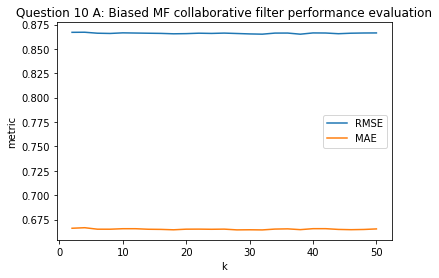

In [ ]:
plt.figure()
plt.plot(K,RMSE)
plt.plot(K,MAE)
plt.legend(['RMSE','MAE'])
plt.xlabel('k')
plt.ylabel('metric')
plt.title('Question 10 A: Biased MF collaborative filter performance evaluation')

B Use the plot from the previous part to find the optimal number of latent factors. Optimal number of latent factors is the value of k that gives the minimum average RMSE or the minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal number of latent factors same as the number of movie genres?

In [ ]:
print('minimum RMSE = ',min(RMSE))
print('minimum MAE = ',min(MAE))
print('optimal k value based on RMSE: ',K[RMSE.index(min(RMSE))])
print('optimal k value based on MAE: ',K[MAE.index(min(MAE))])

minimum RMSE =  0.8650911664778709
minimum MAE =  0.6643642159710414
optimal k value based on RMSE:  38
optimal k value based on MAE:  32


C Performance on dataset subsets: For each of Popular, Unpopular and High-Variance subsets -
* Design a MF collaborative filter to predict the ratings of the movies in the trimmed subset and evaluate its performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds.
* Plot average RMSE (Y-axis) against k (X-axis); item Report the minimum average RMSE.

In [ ]:
K = np.arange(2,52,2)
kf = KFold(n_splits=10)
RMSE = {'popular':[],'unpopular':[],'high_var':[]}
trim_algs = ['popular','unpopular','high_var']
dfs = [data,df_popular,df_unpopular,df_3]

for k in K:
  #print('k=',k)
  model = SVD(n_factors=k, random_state=0)
  reader = Reader(rating_scale=(0.5, 5))

  for (title,df) in zip(trim_algs,dfs):
    df_new = Dataset.load_from_df(df[['userId','movieId','rating']], reader)
    rmse = []
    for trainset, testset in kf.split(df_new):
      
      model.fit(trainset)
      predictions = model.test(testset)

      rmse.append(accuracy.rmse(predictions, verbose=False))

    RMSE[title].append(np.array(rmse).mean())

    #print(f'Done with trimming algorithm: {title}')

minimum RMSE for popular =  0.8647312553485541
optimal k value based on RMSE:  48
minimum RMSE for unpopular =  0.8553068623845259
optimal k value based on RMSE:  28
minimum RMSE for high_var =  0.8956397222494108
optimal k value based on RMSE:  12


Text(0.5, 1.0, 'RMSE vs k for different trimming algorithms')

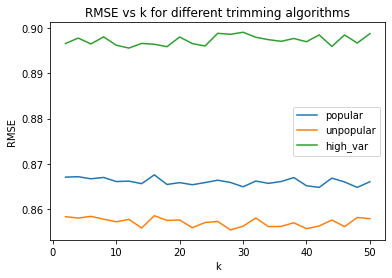

In [ ]:
plt.figure()
for title in trim_algs:
  print(f'minimum RMSE for {title} = ',min(RMSE[title]))
  print('optimal k value based on RMSE: ',K[RMSE[title].index(min(RMSE[title]))])
  plt.plot(K,RMSE[title])
plt.xlabel('k')
plt.ylabel('RMSE')
plt.legend(trim_algs)
plt.title('RMSE vs k for different trimming algorithms')


• Plot the ROC curves for the MF-based collaborative filter and also report the area under the curve (AUC) value as done in Question 6.

working on threshold value=2.5
working on threshold value=3
working on threshold value=3.5
working on threshold value=4


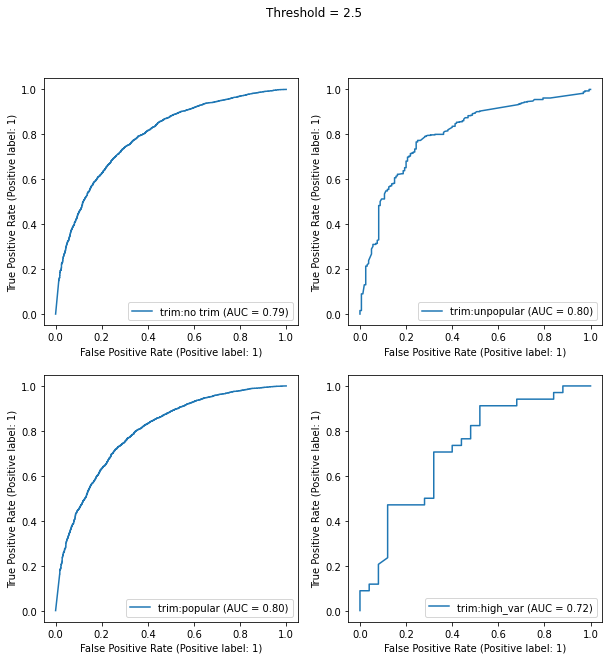

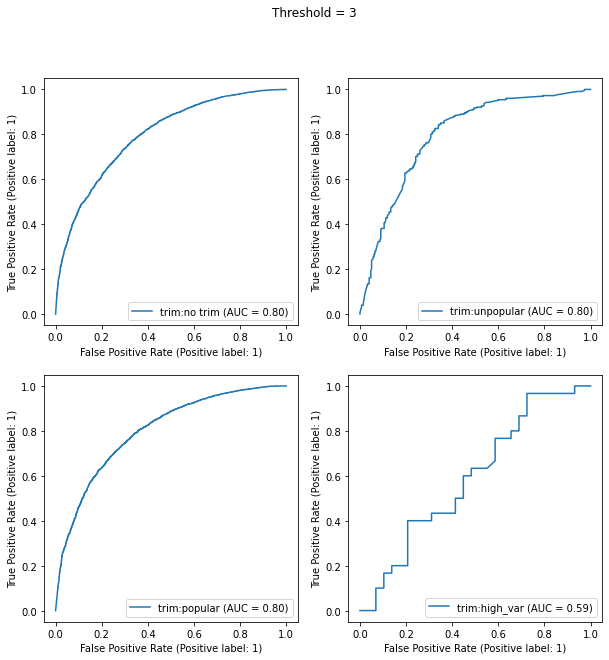

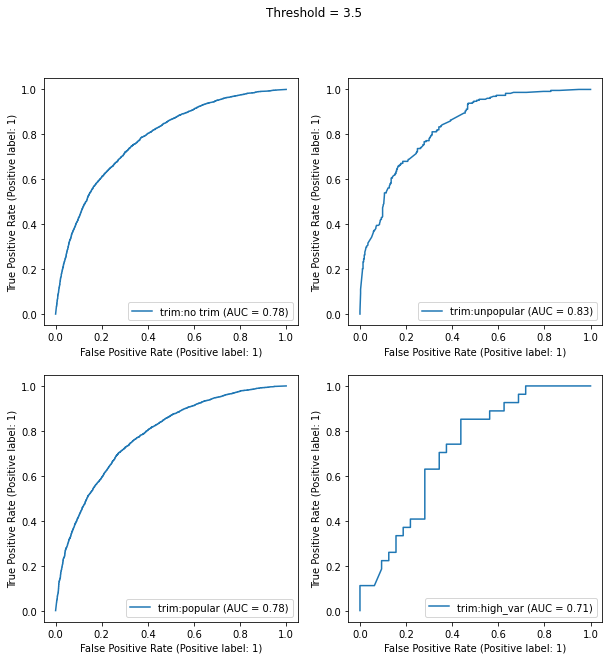

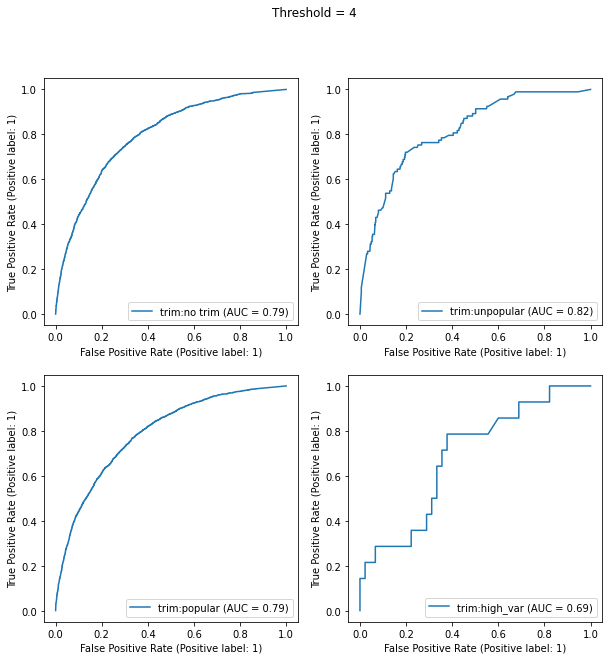

In [ ]:
k= 30 #based on observations in previous step
thresholds = [2.5, 3, 3.5, 4]
dfs = [data,df_popular,df_unpopular,df_3]
trim_algs = ['no trim','popular','unpopular','high_var']
for cutoff in thresholds:

  print(f'working on threshold value={cutoff}')
  model = SVD(n_factors=k, random_state=0)
  reader = Reader(rating_scale=(-1, 1))

  fig, axs = plt.subplots(2,2,figsize=(10,10))
  fig.suptitle(f'Threshold = {cutoff}')

  for (i,df) in enumerate(dfs):

    df1 = df.copy()
    df1['rating'] = df1['rating'].apply(lambda x: 1 if x > cutoff else -1)
    df_new = Dataset.load_from_df(df1[['userId','movieId','rating']], reader)
    trainset, testset = train_test_split(df_new, test_size=0.1)
    model.fit(trainset)
    predictions = model.test(testset)

    y = pd.DataFrame(predictions, 
                     columns=['uid', 'iid', 'rui', 'est', 'details'])
    a = i%2
    b = (i//2)%2
    metrics.RocCurveDisplay.from_predictions(y['rui'], y['est'], 
                                      name=f'trim:{trim_algs[i]}', ax=axs[a,b])


QUESTION 11: Designing a Na ̈ıve Collaborative Filter:

* Design a naive collaborative filter to predict the ratings of the movies in the original dataset and evaluate it’s performance using 10-fold cross validation. Compute the average RMSE by averaging the RMSE across all 10 folds. Report the average RMSE. <br>
 *A trick I used here is that choosing k=0 for k-NN basically gives the naive collaborative filter!*


In [ ]:
from surprise.prediction_algorithms.baseline_only import BaselineOnly
kf = KFold(n_splits=10)
model = KNNWithMeans(k=0,min_k=0,verbose=False)#BaselineOnly()
rmse = []
reader = Reader(rating_scale=(0.5, 5))
df_new = Dataset.load_from_df(data[['userId','movieId','rating']], reader)

for trainset, testset in kf.split(df_new):
      # train and test algorithm.
      model.fit(trainset)
      predictions = model.test(testset)
      # Compute and print Root Mean Squared Error
      rmse.append(accuracy.rmse(predictions, verbose=False))
mean_rmse = np.array(rmse).mean()
print('average RMSE = ',mean_rmse)

average RMSE =  0.9486981155968284


* Performance on dataset subsets: For each of Popular, Unpopular and High-Variance test subsets -
– Design a naive collaborative filter to predict the ratings of the movies in each trimmed set and evaluate it’s performance using 10-fold cross validation.
– Compute the average RMSE by averaging the RMSE across all 10 folds. Report the average RMSE.

In [ ]:

kf = KFold(n_splits=10)
RMSE = {'popular':[],'unpopular':[],'high_var':[]}
trim_algs = ['popular','unpopular','high_var']
dfs = [data,df_popular,df_unpopular,df_3]


model = KNNWithMeans(k=0,min_k=0,verbose=False)#BaselineOnly()
reader = Reader(rating_scale=(0.5, 5))

for (title,df) in zip(trim_algs,dfs):
    df_new = Dataset.load_from_df(df[['userId','movieId','rating']], reader)
    rmse = []
    for trainset, testset in kf.split(df_new):
      
      model.fit(trainset)
      predictions = model.test(testset)

      rmse.append(accuracy.rmse(predictions, verbose=False))

    RMSE[title]=np.array(rmse).mean()

    print(f'Average RMSE for trimming algorithm: {title} is = {RMSE[title]}')

Average RMSE for trimming algorithm: popular is = 0.9486730674525289
Average RMSE for trimming algorithm: unpopular is = 0.9375735640977851
Average RMSE for trimming algorithm: high_var is = 1.051809738029493


QUESTION 12: Comparing the most performant models across architecture: Plot the best ROC curves (threshold = 3) for the k-NN, NMF, and MF with bias based collaborative filters in the same figure. Use the figure to compare the performance of the filters in predicting the ratings of the movies.

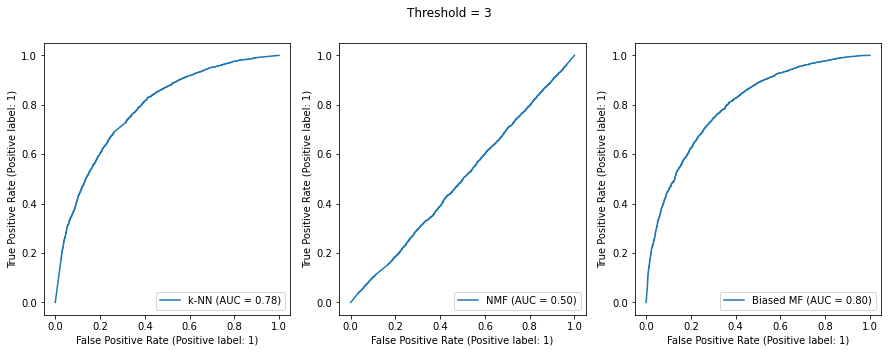

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
fig.suptitle(f'Threshold = 3')
model = [None, None, None]
model[0] = KNNWithMeans(k=20,sim_options={"name": "pearson"}, verbose=False)
model[1] = NMF(n_factors=18, random_state=0, biased=False)
model[2] = SVD(n_factors=20, random_state=0) #to save computational time given that the results are not significantly different for other choises
model_name = ['k-NN','NMF','Biased MF']
reader = Reader(rating_scale=(-1, 1))

df1 = data.copy()
df1['rating'] = df1['rating'].apply(lambda x: 1 if x > 3 else -1)
df_new = Dataset.load_from_df(df1[['userId','movieId','rating']], reader)
trainset, testset = train_test_split(df_new, test_size=0.1)

for i in range(3):

  model[i].fit(trainset)
  predictions = model[i].test(testset)
  y = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details']) 
  metrics.RocCurveDisplay.from_predictions(y['rui'], y['est'], name=model_name[i], ax=axs[i])

QUESTION 13: Understanding Precision and Recall in the context of Recommender Systems: Precision and Recall are defined by the mathematical expressions given by equations 12 and 13 respectively. Please explain the meaning of precision and recall in your own words.<br>
**Precision:** shows what ratio of the recommended movies the user actually likes. <br>
**Recall:** shows the ratio of the liked movies by the user that the system can identify as likable. I.e, how many of the movies the user likes are retrieved by the system?

QUESTION 14: Comparing the precision-recall metrics for the different models:<br>
• For each of the three architectures:
* Plot average precision (Y-axis) against t (X-axis) for the ranking obtained using the model’s
predictions.
* Plot the average recall (Y-axis) against t (X-axis) and plot the average precision (Y-axis) against average recall (X-axis).
* Use the best k found in the previous parts and sweep t from 1 to 25 in step sizes of 1. For each plot, briefly comment on the shape of the plot.

In [ ]:
def calculate_precision_recall(model,df, name):

  df1 = df.copy()
  reader = Reader(rating_scale=(0.5, 5))
  df_new = Dataset.load_from_df(df1[['userId','movieId','rating']], reader)
  kf = KFold(n_splits=2)

  PRECISION = []
  RECALL = []

  for trainset, testset in kf.split(df_new):
        #print('fold ',k)
        #k = k+1
        model.fit(trainset)
        predictions = model.test(testset)
        y = pd.DataFrame(predictions, 
        columns=['uid', 'iid', 'rui', 'est', 'details']).sort_values('rui',ascending=False, ignore_index=True)

        s_precision = [[] for i in range(610)]
        s_recall = [[] for i in range(610)]
        
        
        G = [[] for u in range(610)]
        S = [[] for u in range(610)]
        for (id, true, est, user) in zip(y['iid'],y['rui'], y['est'], y['uid']):
            if true>3:
                G[user-1].append(id)
            if est>3:
                S[user-1].append(id)

        fold_precision = [] #(25,)
        fold_recall = [] #(25,)
        for t in range(1,26):
            prec_t = [] #to average over users for this specific t
            recall_t = []
            for user in range(610):
              if len(G[user])==0 or len(S[user])<t:
                continue
              
              p = len(list(set(G[user])&set(S[user][:t])))/len(S[user][:t])
              r = len(list(set(G[user])&set(S[user][:t])))/len(G[user])
              prec_t.append(p)
              recall_t.append(r)
            
            #save the average across users for this t:
            fold_precision.append(np.array(prec_t).mean())
            fold_recall.append(np.array(recall_t).mean())

        PRECISION.append(fold_precision) 
        RECALL.append(fold_recall)

  final_precision =  np.array(PRECISION).mean(axis=0)      
  final_recall =  np.array(RECALL).mean(axis=0) 

  return final_precision, final_recall      



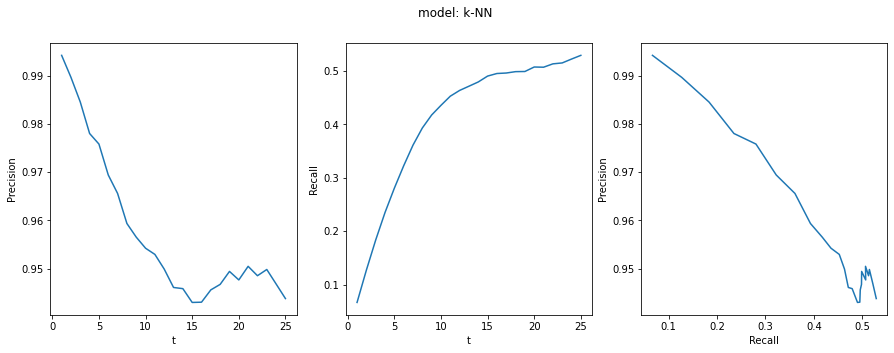

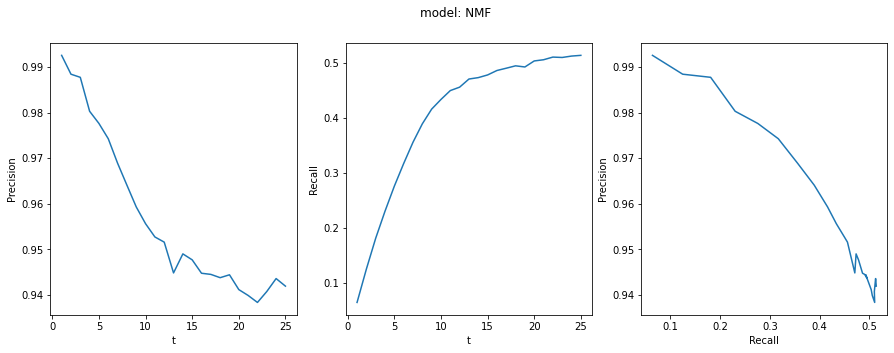

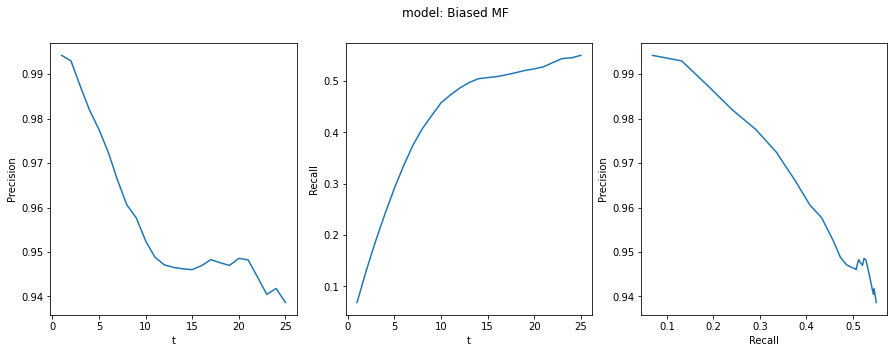

In [ ]:
model = [None, None, None]
model[0] = KNNWithMeans(k=20,sim_options={"name": "pearson"}, verbose=False)
model[1] = NMF(n_factors=18, random_state=0, biased=False)
model[2] = SVD(n_factors=20, random_state=0)
model_name = ['k-NN','NMF','Biased MF']
  
p = [None, None, None]
r = [None, None, None]
for i in range(3):

  fig, axs = plt.subplots(1,3,figsize=(15,5))
  p[i],r[i] = calculate_precision_recall(model[i],data, model_name[i])
  fig.suptitle(f'model: {model_name[i]}')
  axs[0].plot(range(1,26),p[i])
  axs[1].plot(range(1,26),r[i])
  axs[2].plot(r[i],p[i])
  axs[0].set_xlabel('t')
  axs[0].set_ylabel('Precision')
  axs[1].set_xlabel('t')
  axs[1].set_ylabel('Recall')
  axs[2].set_xlabel('Recall')
  axs[2].set_ylabel('Precision')



Plot the best precision-recall curves obtained for the three models (k-NN, NMF, MF) in the same figure. Use this figure to compare the relevance of the recommendation list generated using k-NN, NMF, and MF with bias predictions.<br>
*Please see the figure below. Noting that the 3 curves are very close to each other, we can conclude that the 3 models have a relatively similar performance in recommending movies and they are actually recommending a good list!*

Text(0.5, 1.0, 'Q14: Precision vs Recall curve')

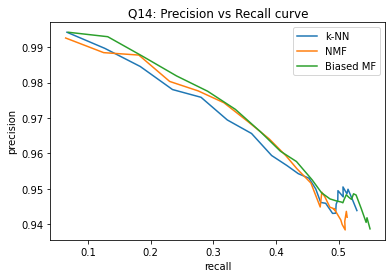

In [ ]:
plt.figure()
for i in range(3):
  plt.plot(r[i],p[i])
plt.ylabel('precision')
plt.xlabel('recall')
plt.legend(model_name)
plt.title('Q14: Precision vs Recall curve')